In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
device = 'cuda'
print(f'Memory allocated: {torch.cuda.memory_allocated()}')

Memory allocated: 0


# Project meta json to check the overall structure

In [5]:
import json
from PIL import Image
import matplotlib.pyplot as plt

# Path to JSON file and image file
json_file_path = "/content/drive/MyDrive/DS-OCR/meta.json"

# Load JSON data
with open(json_file_path, "r", encoding="utf-8") as json_file:
    json_data = json.load(json_file)

# Print JSON structure
print("JSON Structure:")
print(json.dumps(json_data, indent=4))

JSON Structure:
{
    "classes": [
        {
            "title": "Body text",
            "shape": "rectangle",
            "color": "#BD2AEA",
            "geometry_config": {},
            "id": 10214732,
            "hotkey": "B"
        },
        {
            "title": "Title",
            "shape": "rectangle",
            "color": "#557AC3",
            "geometry_config": {},
            "id": 10214731,
            "hotkey": "T"
        },
        {
            "title": "Page",
            "shape": "polygon",
            "color": "#BECE6F",
            "geometry_config": {},
            "id": 10214730,
            "hotkey": "P"
        }
    ],
    "tags": [
        {
            "name": "Redacted",
            "value_type": "none",
            "color": "#D4DF53",
            "id": 30308108,
            "hotkey": "R",
            "applicable_type": "imagesOnly",
            "classes": []
        },
        {
            "name": "Transcription",
            "value_type": "any_str

# Reading Images and drawing bounding boxes

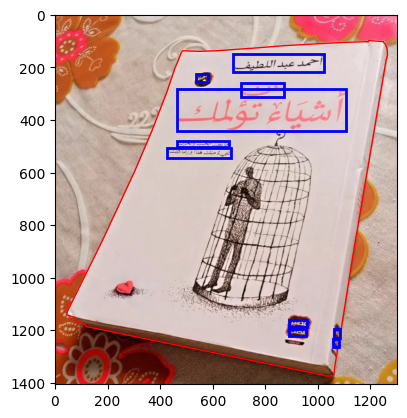

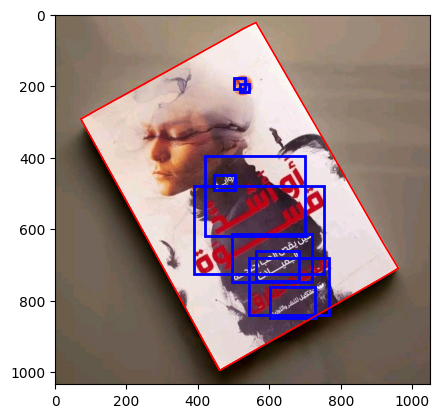

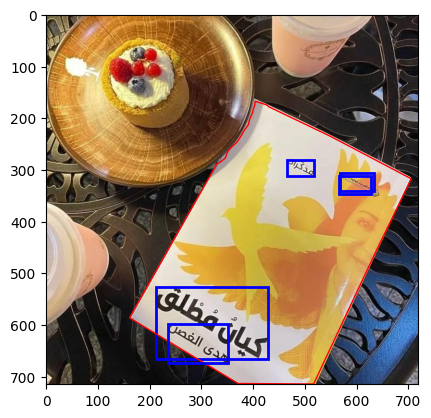

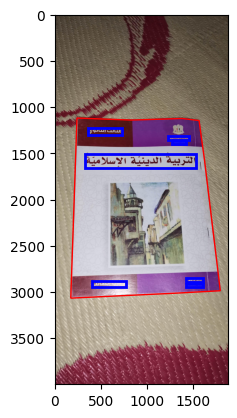

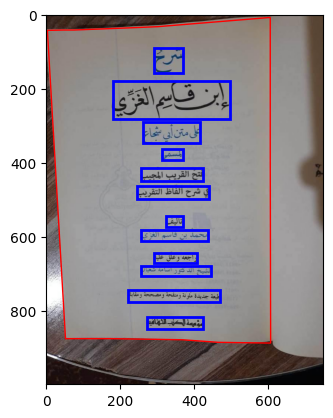

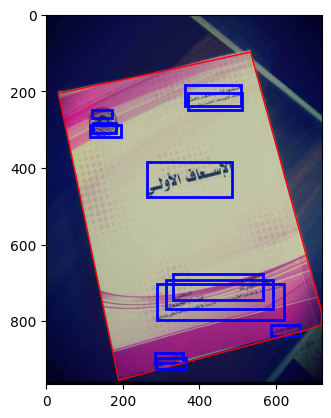

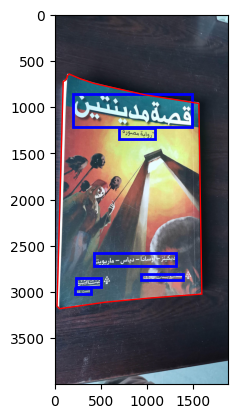

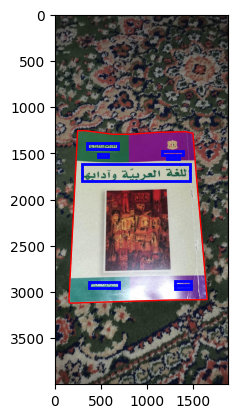

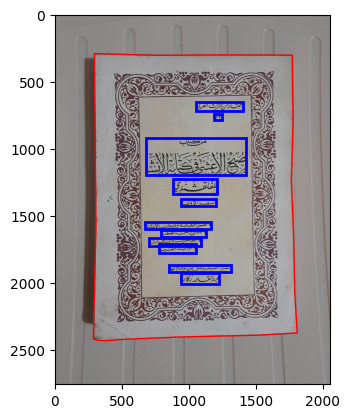

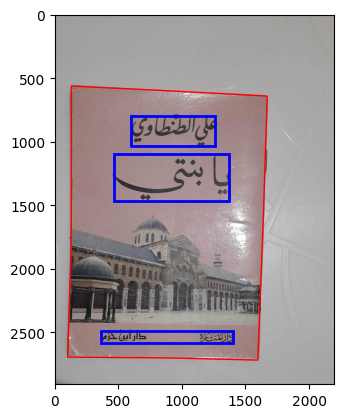

In [8]:
import os
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Folder paths
ann_folder = "/content/drive/MyDrive/DS-OCR/ann"
img_folder = "/content/drive/MyDrive/DS-OCR/img"

# Counter for the number of images displayed
num_images_displayed = 0

# Iterate over JSON files in the 'ann' folder
for filename in os.listdir(ann_folder):
    if filename.endswith(".json"):
        # Load JSON data from the file
        json_file_path = os.path.join(ann_folder, filename)
        with open(json_file_path, "r", encoding="utf-8") as json_file:
            data = json.load(json_file)

        # Access objects
        objects = data["objects"]

        # Find corresponding image file
        img_filename_base = os.path.splitext(filename)[0]  # Get filename without extension
        img_extensions = (".jpg", ".jpeg", ".png")
        img_path = None
        for ext in img_extensions:
            img_candidate_path = os.path.join(img_folder, img_filename_base + ext)
            if os.path.exists(img_candidate_path):
                img_path = img_candidate_path
                break

        if img_path is None:
            print(f"No corresponding image found for {filename}")
            continue

        # Load the image and rotate it to correct orientation if needed
        image = Image.open(img_path)
        if hasattr(image, "_getexif"):  # Check if image has EXIF data (orientation)
            exif = image._getexif()
            if exif:
                orientation = exif.get(274, 1)  # Default orientation is 1 if not found in EXIF data
                rotation_angle = 0

                if orientation == 3:  # Rotate by 180 degrees
                    rotation_angle = 180
                elif orientation == 6:  # Rotate clockwise by 90 degrees
                    rotation_angle = -90
                elif orientation == 8:  # Rotate counterclockwise by 90 degrees
                    rotation_angle = 90

                # Rotate the image if the orientation requires it
                if rotation_angle != 0:
                    image = image.rotate(rotation_angle, expand=True)

        # Create figure and axis
        fig, ax = plt.subplots(1)

        # Display the image
        ax.imshow(image)

        # Define a function to draw polygons based on exterior points
        def draw_polygon(ax, points, color='r'):
            # Create and add the polygon patch to the plot
            polygon = patches.Polygon(points, closed=True, fill=None, edgecolor=color)
            ax.add_patch(polygon)

        # Define a function to draw rectangles based on exterior points
        def draw_rectangle(ax, points, color='b'):
            # Calculate the coordinates of the top-left corner and the width and height of the rectangle
            x1 = min(points[0][0], points[1][0])
            y1 = min(points[0][1], points[1][1])
            width = abs(points[0][0] - points[1][0])
            height = abs(points[0][1] - points[1][1])

            # Create and add the rectangle patch to the plot
            rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor=color, fill=None)
            ax.add_patch(rect)

        # Iterate through objects and draw polygons or rectangles based on the geometry type
        for obj in objects:
            exterior_points = obj["points"]["exterior"]
            if obj["geometryType"] == "polygon":
                draw_polygon(ax, exterior_points)
            elif obj["geometryType"] == "rectangle":
                draw_rectangle(ax, exterior_points)

        # Show plot
        plt.show()

        # Increment the counter
        num_images_displayed += 1

        # Check if 5 images have been displayed
        if num_images_displayed >= 10:
            break


# Transform DS to YOLOV5 format


Convert bboxes from ds format to yolo format

In [14]:
def convert_bbox_to_yolo_format(title, img_width, img_height, xmin, ymin, xmax, ymax):
    """
    Convert bounding box coordinates to YOLO format.

    Args:
        img_width (int): Width of the image.
        img_height (int): Height of the image.
        xmin (float): Top left x-coordinate of the bounding box.
        ymin (float): Top left y-coordinate of the bounding box.
        xmax (float): Bottom right x-coordinate of the bounding box.
        ymax (float): Bottom right y-coordinate of the bounding box.

    Returns:
        tuple: (x_center, y_center, width, height) in YOLO format.
    """
    # Calculate the center of the bounding box
    x_center = (xmin + xmax) / 2 / img_width
    y_center = (ymin + ymax) / 2 / img_height

    # Calculate the width and height of the bounding box
    width = (xmax - xmin) / img_width
    height = (ymax - ymin) / img_height

    return title, x_center, y_center, width, height

Run the aforementioned function on all the files in the ann folder and write .txt files

In [32]:
import os
import json
from PIL import Image

ann_folder = "/content/drive/MyDrive/DS-OCR/ann"
img_folder = "/content/drive/MyDrive/DS-OCR/img"

data_folder = "/content/drive/MyDrive/DS-OCR/data/"
labels_folder = data_folder+"labels/"
images_folder = data_folder+"images/"


# Create the folder if it doesn't exist
if not os.path.exists(data_folder):
    os.makedirs(data_folder)
    print(f"Folder '{data_folder}' created.")

if not os.path.exists(labels_folder):
    os.makedirs(labels_folder)
    print(f"Folder '{labels_folder}' created.")

if not os.path.exists(images_folder):
    os.makedirs(images_folder)
    print(f"Folder '{images_folder}' created.")



for filename in os.listdir(ann_folder):
    name, extension = os.path.splitext(filename)
    if filename.endswith(".json"):
        # Load JSON data from the file
        json_file_path = os.path.join(ann_folder, filename)
        with open(json_file_path, "r", encoding="utf-8") as json_file:
            data = json.load(json_file)

        # Access objects and retrieving image size
        objects = data["objects"]

        img_width = data["size"]["width"]
        img_height = data["size"]["height"]

        # Write the space-separated string to a text file (YOLO FORMAT)
        label_path = labels_folder+name+'.txt'
        labels = []
        for obj in objects:
              points = obj["points"]["exterior"]
              if obj["classTitle"] == "Title":
                labels.append(convert_bbox_to_yolo_format(0,img_width,img_height,points[0][0], points[0][1],points[1][0], points[1][1]))
              elif obj["classTitle"] == "Body text":
                labels.append(convert_bbox_to_yolo_format(1,img_width,img_height,points[0][0], points[0][1],points[1][0], points[1][1]))

        with open(label_path, 'w', encoding='utf-8') as label_file:
            # Write objects in labels folder
            for idx, label in enumerate(labels):
              label_str = ' '.join(map(str, label))
              if idx == len(labels)-1:
                label_file.write(label_str)
              else:
                label_file.write(label_str + '\n')



Simply copy images from their img directory to images directory

In [19]:
!cp '/content/drive/MyDrive/DS-OCR/img/' '/content/drive/MyDrive/DS-OCR/data/images/' --recursive

# Testing Migrated Data

In [38]:
# from PIL import Image, ImageDraw

# def show_bbox(image_path):
#     # convert image path to label path
#     label_path = image_path.replace('/images/', '/labels/')
#     for ext in ['.jpeg', '.png', '.jpg']:
#         if label_path.endswith(ext):
#             label_path = label_path.replace(ext, '.txt')

#     # Open the image and create ImageDraw object for drawing
#     image = Image.open(image_path)
#     draw = ImageDraw.Draw(image)

#     with open(label_path, 'r') as f:
#         for line in f.readlines():
#             # Split the line into five values
#             label, x, y, w, h = line.split(' ')

#             # Convert string into float
#             x = float(x)
#             y = float(y)
#             w = float(w)
#             h = float(h)

#             # Convert center position, width, height into
#             # top-left and bottom-right coordinates
#             W, H = image.size
#             x1 = (x - w/2) * W
#             y1 = (y - h/2) * H
#             x2 = (x + w/2) * W
#             y2 = (y + h/2) * H

#             # Draw the bounding box with red lines
#             draw.rectangle((x1, y1, x2, y2),
#                            outline=(255, 0, 0), # Red in RGB
#                            width=5)             # Line width
#     image.show()

In [3]:
from PIL import Image, ImageDraw
from IPython.display import display

def show_bbox(image_path):
    # convert image path to label path
    label_path = image_path.replace('/images/', '/labels/')
    for ext in ['.jpeg', '.png', '.jpg']:
        if label_path.endswith(ext):
            label_path = label_path.replace(ext, '.txt')

    # Open the image and create ImageDraw object for drawing
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)

    with open(label_path, 'r') as f:
        for line in f.readlines():
            # Split the line into five values
            label, x, y, w, h = line.split(' ')

            # Convert string into float
            x = float(x)
            y = float(y)
            w = float(w)
            h = float(h)

            # Convert center position, width, height into
            # top-left and bottom-right coordinates
            W, H = image.size
            x1 = (x - w/2) * W
            y1 = (y - h/2) * H
            x2 = (x + w/2) * W
            y2 = (y + h/2) * H

            # Draw the bounding box with red lines
            draw.rectangle((x1, y1, x2, y2),
                           outline=(255, 0, 0), # Red in RGB
                           width=5)             # Line width
    display(image)

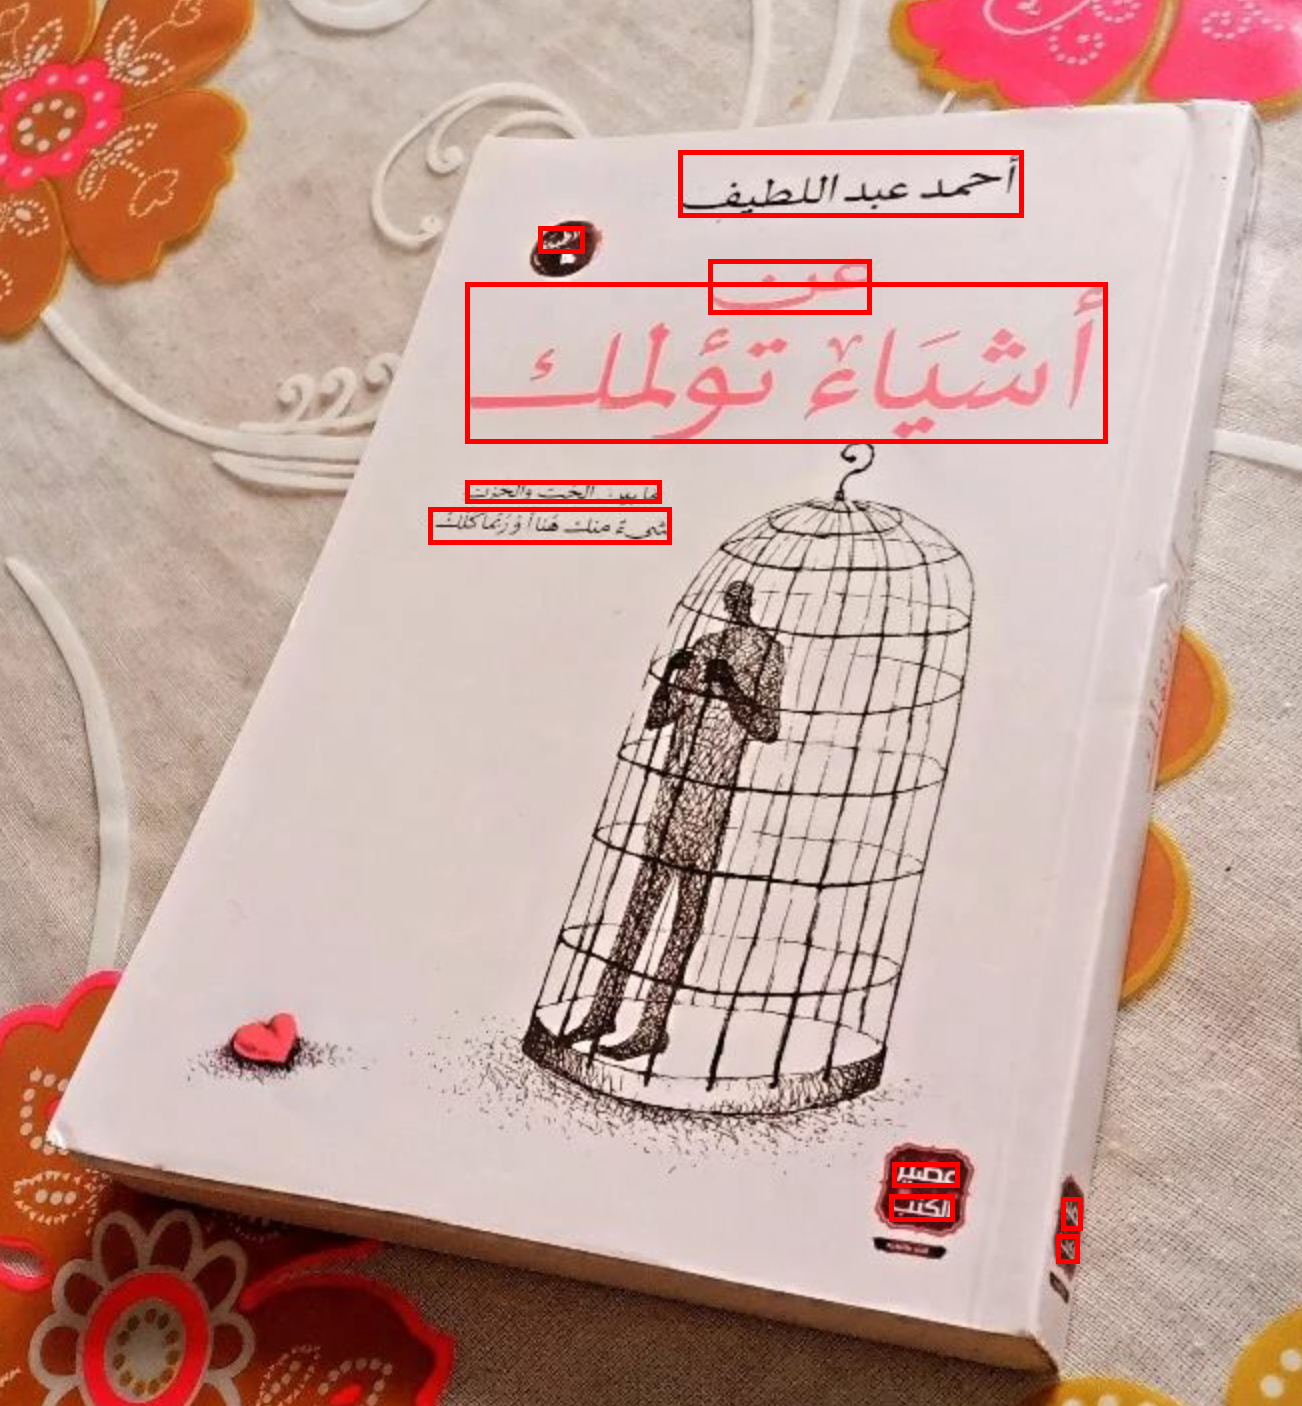

In [50]:
show_bbox('/content/drive/MyDrive/DS-OCR/data/images/001.png')

# Split our Dataset to Train and Test

Create folders if needed

In [51]:
import os

# Create a folder structure for YOLOv5 training
for folder in ['/images', '/labels']:
  for split in ['/train', '/val', '/test']:
    os.makedirs('/content/drive/MyDrive/DS-OCR/data'+folder+split)

Split images

In [8]:
import shutil
import os

def split_dataset(dataset_folder, train_size, val_size):
      i=1
      for filename in os.listdir(dataset_folder+'/images/'):
        if os.path.isfile(os.path.join(dataset_folder+'/images/', filename)):
          name, extension = os.path.splitext(filename)

          if i < train_size:
              split = 'train'
          elif i < train_size + val_size:
              split = 'val'
          else:
              split = 'test'

          # Source paths
          source_image_path = dataset_folder+'/images/'+filename
          source_label_path =  dataset_folder+'/labels/'+name+".txt"

          # Destination paths
          target_image_folder = dataset_folder+'/images/'+split+'/'+filename
          target_label_folder = dataset_folder+'/labels/'+split+'/'+name+".txt"

          # Copy files
          shutil.copy(source_image_path, target_image_folder)
          shutil.copy(source_label_path, target_label_folder)
          i+=1

# Cat data
split_dataset('/content/drive/MyDrive/DS-OCR/data', train_size=671, val_size=83)

# Cleaning images in the data folder (you wont need this)

In [11]:
import os

def delete_files_in_folder(folder_path):
    for item in os.listdir(folder_path):
        item_path = os.path.join(folder_path, item)
        if os.path.isfile(item_path):
            os.remove(item_path)
            print(f"Deleted file: {item_path}")

# Example usage
folder_path = '/content/drive/MyDrive/DS-OCR/data/labels'
delete_files_in_folder(folder_path)


Deleted file: /content/drive/MyDrive/DS-OCR/data/labels/001.txt
Deleted file: /content/drive/MyDrive/DS-OCR/data/labels/0010.txt
Deleted file: /content/drive/MyDrive/DS-OCR/data/labels/00100.txt
Deleted file: /content/drive/MyDrive/DS-OCR/data/labels/00101.txt
Deleted file: /content/drive/MyDrive/DS-OCR/data/labels/00102.txt
Deleted file: /content/drive/MyDrive/DS-OCR/data/labels/00103.txt
Deleted file: /content/drive/MyDrive/DS-OCR/data/labels/00104.txt
Deleted file: /content/drive/MyDrive/DS-OCR/data/labels/00105.txt
Deleted file: /content/drive/MyDrive/DS-OCR/data/labels/00106.txt
Deleted file: /content/drive/MyDrive/DS-OCR/data/labels/00107.txt
Deleted file: /content/drive/MyDrive/DS-OCR/data/labels/00108.txt
Deleted file: /content/drive/MyDrive/DS-OCR/data/labels/00109.txt
Deleted file: /content/drive/MyDrive/DS-OCR/data/labels/0011.txt
Deleted file: /content/drive/MyDrive/DS-OCR/data/labels/00110.txt
Deleted file: /content/drive/MyDrive/DS-OCR/data/labels/00111.txt
Deleted file: 

# Load Labels/ Classes

# Dataset Class to return image and corresponding mask

In [ ]:
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms

class CustomDataset(Dataset):
    def __init__(self, img_folder, mask_folder, transform=None, target_size=(256, 256)):
        self.img_folder = img_folder
        self.mask_folder = mask_folder
        self.transform = transform
        self.target_size = target_size

        self.img_filenames = sorted([filename for filename in os.listdir(img_folder) if filename.endswith((".jpg", ".jpeg", ".png"))])
        self.mask_filenames = sorted([filename for filename in os.listdir(mask_folder) if filename.endswith(".png")])

    def __len__(self):
        return len(self.img_filenames)

    def __getitem__(self, idx):
        img_filename = self.img_filenames[idx]
        mask_filename = img_filename.split('.')[0] + '_mask.png'

        img_path = os.path.join(self.img_folder, img_filename)
        mask_path = os.path.join(self.mask_folder, mask_filename)

        # Load image
        image = Image.open(img_path).convert("RGB")

        # Load mask
        mask = Image.open(mask_path)

        # Resize image and mask
        image = image.resize(self.target_size, Image.BILINEAR)
        mask = mask.resize(self.target_size, Image.NEAREST)

        # Apply transformations if specified
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

# Define transformations for images and masks
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image to tensor
])

# Example usage:
dataset = CustomDataset(img_folder="/kaggle/working/rotated_images",
                        mask_folder="/kaggle/working/masks",
                       transform=transform,
                       target_size=(224, 224))
image, mask = dataset[1]
print(image.size, mask.size)


In [ ]:
import matplotlib.pyplot as plt

# Convert image and mask to numpy arrays
image_np = np.array(image.permute(1,2,0))
mask_np = np.array(mask.permute(1,2,0))

# Display image and mask
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image_np)
axes[0].set_title('Image')
axes[0].axis('off')
axes[1].imshow(mask_np, cmap='gray')
axes[1].set_title('Mask')
axes[1].axis('off')
plt.show()


# DataLoader Configs

In [ ]:
# Initialize the dataset
# dataset = CustomDataset(img_folder="/kaggle/working/rotated_images", mask_folder="/kaggle/working/masks", transform=transform)
from torch.utils.data import Dataset, DataLoader, random_split  # Import random_split

# Split dataset into train, validation, and test sets
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

num_data = len(dataset)
num_train = int(train_ratio * num_data)
num_val = int(val_ratio * num_data)
num_test = num_data - num_train - num_val

train_set, val_set, test_set = random_split(dataset, [num_train, num_val, num_test])

# Initialize data loaders for train, validation, and test sets
batch_size = 8  # Set your desired batch size
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size)
test_loader = DataLoader(test_set, batch_size=batch_size)


In [ ]:
g ,h = next(iter(train_loader))
g.shape , h.shape

# Double Check everything

In [ ]:
g[0].shape , h[0].shape

# Convert image and mask to numpy arrays
image_np = np.array(g[1].permute(1,2,0))
mask_np = np.array(h[1].permute(1,2,0))

# Display image and mask
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image_np)
axes[0].set_title('Image')
axes[0].axis('off')
axes[1].imshow(mask_np, cmap='gray')
axes[1].set_title('Mask')
axes[1].axis('off')
plt.show()


In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms

# Assuming you have a data loader named 'dataloader'
# Make sure you have already loaded your CustomImageMaskDataset

# Define inverse transforms to convert tensors back to PIL images
inv_transform = transforms.Compose([
    transforms.ToPILImage(),
])

# Iterate through the data loader
for batch in train_loader:
    images, masks = batch

    # Visualize the first image and its mask
    image_to_show = inv_transform(images[0].cpu())
    mask_to_show = inv_transform(masks[0].cpu())

    # Plot the original image
    plt.subplot(1, 3, 1)
    plt.imshow(image_to_show)
    plt.title('Original Image')

    # Plot the corresponding mask
    plt.subplot(1, 3, 2)
    plt.imshow(mask_to_show, cmap='gray')  # Assuming binary masks
    plt.title('Corresponding Mask')

    # Plot the pixel value distribution in the mask
    plt.subplot(1, 3, 3)
    mask_values = masks[0].view(-1).numpy()
    plt.hist(mask_values, bins=np.arange(-0.5, 2, 1), rwidth=0.8, color='blue', alpha=0.7)
    plt.xticks([0, 1], ['Background', 'Foreground'])
    plt.title('Distribution of Mask Pixel Values')

    plt.show()

    break  # Break after the first batch to avoid plotting multiple images


In [ ]:
import torch
device = 'cuda'
print(f'Memory allocated: {torch.cuda.memory_allocated()}')

In [ ]:
torch.cuda.memory_allocated()

# Now we're Good togo and do the model building

In [ ]:
# GPU
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

# Getting unet pretrained models

In [ ]:
# %%capture
!pip install segmentation-models-pytorch

In [ ]:
import segmentation_models_pytorch as smp

# Define Model
# model = smp.Unet(classes = 1)
model = smp.Unet(encoder_name = "timm-efficientnet-b8",
             encoder_weights = "imagenet",
             in_channels = 3,
             classes = 1)

In [ ]:
import torchinfo
torchinfo.summary(model = model,
        col_width = 17,
        input_size = [1,3,224,224],
        col_names = ['input_size','output_size','num_params','trainable'],
        row_settings = ['var_names'])

In [ ]:
# We freeze the encoder layer.
for param in model.encoder.parameters():
    param.requires_grad = False

In [ ]:
torchinfo.summary(model = model,
        col_width = 17,
        input_size = [1,3,224,224],
        col_names = ['input_size','output_size','num_params','trainable'],
        row_settings = ['var_names'])

In [ ]:
from segmentation_models_pytorch.metrics import get_stats, iou_score

loss_fn = smp.losses.DiceLoss(mode = 'binary', from_logits = True)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01, weight_decay = 0.0001)

In [ ]:
class EarlyStopping:
    def __init__(self, patience:int = 5, delta:float = 0.0001, path = "best_model.pth"):
        self.patience = patience
        self.delta = delta
        self.path = path
        self.best_score = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
            self.save_checkpoint(model)

        elif val_loss >= self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

        else:
            self.best_score = val_loss
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.path)


In [ ]:
# Define EarlyStopping
early_stopping = EarlyStopping(patience = 10, delta = 0.)

In [ ]:
from tqdm.autonotebook import tqdm

In [ ]:
def train_step(model:torch.nn.Module, dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module, optimizer:torch.optim.Optimizer):

    model.train()

    train_loss = 0.
    train_iou = 0.

    for batch, (X,y) in enumerate(tqdm(dataloader)):
        X = X.to(device, dtype = torch.float32)
        y = y.to(device, dtype = torch.float32)
        optimizer.zero_grad()
        logit_mask = model(X)
        loss = loss_fn(logit_mask, y)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()

        prob_mask = logit_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        tp,fp,fn,tn = get_stats(output = pred_mask.detach().cpu().long(),
                                target = y.cpu().long(),
                                mode = "binary")

        train_iou += iou_score(tp, fp, fn, tn, reduction = "micro").numpy()

    train_loss = train_loss / len(dataloader)
    train_iou = train_iou / len(dataloader)

    return train_loss, train_iou

In [ ]:
def val_step(model:torch.nn.Module,
             dataloader:torch.utils.data.DataLoader,
             loss_fn:torch.nn.Module):

    model.eval()

    val_loss = 0.
    val_iou = 0.

    with torch.inference_mode():
        for batch,(X,y) in enumerate(tqdm(dataloader)):
            X = X.to(device, dtype = torch.float32)
            y = y.to(device, dtype = torch.float32)
            logit_mask = model(X)
            loss = loss_fn(logit_mask, y)
            val_loss += loss.item()

            prob_mask = logit_mask.sigmoid()
            pred_mask = (prob_mask > 0.5).float()

            tp, fp, fn, tn = get_stats(output = pred_mask.detach().cpu().long(),
                                       target = y.cpu().long(),
                                       mode = "binary")

            val_iou += iou_score(tp, fp, fn, tn, reduction = "micro").numpy()

    val_loss = val_loss / len(dataloader)
    val_iou = val_iou / len(dataloader)

    return val_loss, val_iou



In [ ]:
def train(model:torch.nn.Module, train_dataloader:torch.utils.data.DataLoader,
          val_dataloader:torch.utils.data.DataLoader, loss_fn:torch.nn.Module,
          optimizer:torch.optim.Optimizer, early_stopping, epochs:int = 10):

    results = {'train_loss':[], 'train_iou':[], 'val_loss':[], 'val_iou':[]}

    for epoch in tqdm(range(epochs)):
        train_loss, train_iou = train_step(model = model,
                                           dataloader = train_dataloader,
                                           loss_fn = loss_fn,
                                           optimizer = optimizer)

        val_loss, val_iou = val_step(model = model,
                                     dataloader = val_dataloader,
                                     loss_fn = loss_fn)

        print(f'Epoch: {epoch + 1} | ',
              f'Train Loss: {train_loss:.4f} | ',
              f'Train IOU: {train_iou:.4f} | ',
              f'Val Loss: {val_loss:.4f} | ',
              f'Val IOU: {val_iou:.4f}')

        early_stopping(val_loss, model)

        if early_stopping.early_stop == True:
            print("Early Stopping!!!")
            break

        results['train_loss'].append(train_loss)
        results['train_iou'].append(train_iou)
        results['val_loss'].append(val_loss)
        results['val_iou'].append(val_iou)

    return results

In [ ]:
# Training!!!
SEED = 42
EPOCHS = 100
torch.cuda.manual_seed(SEED)
torch.manual_seed(SEED)

RESULTS = train(model.to(device),
                train_loader,
                val_loader,
                loss_fn,
                optimizer,
                early_stopping,
                EPOCHS)

In [ ]:
def loss_and_metric_plot(results:dict):
    plt.style.use("ggplot")

    training_loss = results['train_loss']
    training_metric = results['train_iou']
    valid_loss = results['val_loss']
    valid_metric = results['val_iou']

    fig,ax = plt.subplots(nrows = 1, ncols = 2, figsize = (9,4))
    ax = ax.flat

    ax[0].plot(training_loss, color = "red", label = 'Train')
    ax[0].plot(valid_loss, color = "blue", label = 'Valid')
    ax[0].set_ylabel("Loss", fontsize = 8, fontweight = "bold", color = "black")
    ax[0].set_xlabel("Epoch", fontsize = 8, fontweight = "bold", color = "black")
    ax[0].set_title("DiceLoss", fontsize = 11, fontweight = "bold", color = "black")

    ax[1].plot(training_metric, color = "red", label = 'Train')
    ax[1].plot(valid_metric, color = "blue", label = 'Valid')
    ax[1].set_ylabel("Score", fontsize = 8, fontweight = "bold", color = "black")
    ax[1].set_xlabel("Epoch", fontsize = 8, fontweight = "bold", color = "black")
    ax[1].set_title("IOU", fontsize = 11, fontweight = "bold", color = "black")

    ax[0].legend()
    ax[1].legend()
    fig.tight_layout()
    fig.show()

In [ ]:
loss_and_metric_plot(RESULTS)

# Predictions

In [ ]:
def predictions(test_dataloader:torch.utils.data.DataLoader):

    loaded_model = smp.Unet(encoder_name = "timm-efficientnet-b8",
                        encoder_weights = None,
                        in_channels = 3,
                        classes = 1)

    checkpoint = torch.load("/kaggle/working/best_model.pth")

    loaded_model.load_state_dict(checkpoint)

    loaded_model.to(device)

    loaded_model.eval()

    pred_mask_test = []

    with torch.inference_mode():
        for X,_ in tqdm(test_loader):
            X = X.to(device, dtype = torch.float)
            logit_mask = loaded_model(X)
            prob_mask = logit_mask.sigmoid()
            pred_mask = (prob_mask > 0.5).float()
            pred_mask_test.append(pred_mask.detach().cpu())

    pred_mask_test = torch.cat(pred_mask_test)

    return pred_mask_test

In [ ]:
pred_mask_test = predictions(test_loader)

In [ ]:
# We are going to create our tensors so we can plot later.
IMAGE_TEST = []
MASK_TEST = []

for img,mask in test_loader:
  IMAGE_TEST.append(img)
  MASK_TEST.append(mask)

IMAGES_TEST = torch.cat(IMAGE_TEST)

MASKS_TEST = torch.cat(MASK_TEST)

In [ ]:
TP, FP, FN, TN = get_stats(pred_mask_test.long(),
                           (MASKS_TEST>0.5).float().long(),
                           mode = "binary")

# Final Metric -- 54 % IOU

In [ ]:
iou_test = iou_score(TP, FP, FN, TN, reduction = "micro")
print(f'IOU Test = {iou_test:.4f}')

In [ ]:
# We visualize each prediction and its respective original mask.
fig, ax = plt.subplots(nrows = 44, ncols = 2, figsize = (30, 120))

for i,(j,k) in enumerate(zip(MASKS_TEST, pred_mask_test)):

    if i>43:
        break

    ax[i,0].imshow(j.squeeze().numpy(), alpha = 0.8)
    ax[i,0].set_title("Original", fontsize = 10, fontweight = "bold")
    ax[i,0].axis('off')

    ax[i,1].imshow(k.squeeze().numpy(), alpha = 0.8)
    ax[i,1].set_title("Predicted", fontsize = 10, fontweight = "bold")
    ax[i,1].axis('off')


fig.tight_layout()
fig.show()